# Simulation of chirp compression

June 21, 2018

Reference: 
- [Sound Synthesis with Numpy](https://dzone.com/articles/sound-synthesis-numpy)
- [Decoding LoRa, a Wireless
Network for the Internet of Things](https://www.rsaconference.com/writable/presentations/file_upload/hta-f01-decoding-lora-a-wireless-network-for-the-internet-of-things_copy1.pdf)
- [LoRa Reverse Engineering and AES ](https://fosdem.org/2018/schedule/event/sdr_lora_aes/attachments/slides/2357/export/events/attachments/sdr_lora_aes/slides/2357/LoRa_AES_Security_SDR_FOSDEM_2018.pdf)
- [Radar Pulse Compression](https://www.ittc.ku.edu/workshops/Summer2004Lectures/Radar_Pulse_Compression.pdf)

## Conclusion of this simulation

In this simulation, Chirp compression in frequency domain (received signal * reference signal, then FFT) showed a better result than Chirp compression in time domain (reference signal as matched filter). But, time-frame synchronization problems remain in the former case.

I consulted the page "Correlation processing of chirp signals" in the material "[Radar Pulse Compression](https://www.ittc.ku.edu/workshops/Summer2004Lectures/Radar_Pulse_Compression.pdf)". However, actual experimentaton on STM32L4 showed a worse result than "Chirp compression in frequency domain". So I have decided to follow the last page of the material to compress chirp in freq domain.

In [2]:
%matplotlib inline

from numpy import zeros, append, linspace, sin, cos, exp, pi, int16, abs, real, imag, random, sqrt, log10
from scipy.io.wavfile import write
from scipy.signal import spectrogram
from scipy.fftpack import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
import peakutils
import pandas
from IPython.display import display, Audio

In [3]:
#SAMPLING_RATE = 8000  # Hz
SAMPLING_RATE = 44100  # Hz
SAMPLES = 2048
TIME_FRAME = SAMPLES/SAMPLING_RATE # Time frame in sec
AMPLITUDE = 20000 # 16bit PCM max amplitude

# Chirp sweep range in Hz
F1 = 880
F2 = 1760

WAVE_FILE="./ChirpTone.wav"

## Chirp tone synthesis

In [4]:
# Complex version of chirp tone generator
def chirp(amp=AMPLITUDE, updown="up", length=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, length, int(length * SAMPLING_RATE))
    delta = float(F2 - F1)/float(length)
    if (updown == "up"):
        freq = F1 + delta * t
    elif (updown == "down"):
        freq = F2 - delta * t
    arg = (2 * pi * freq * t) * rot + phase
    return exp(1j * arg) * amp

# Real version of chirp tone generator
def chirp_cos(f1=F1, f2=F2, amp=AMPLITUDE, updown="up", length=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, length, int(length * SAMPLING_RATE))
    delta = float(f2 - f1)/float(length)
    if (updown == "up"):
        freq = f1 + delta * t
    elif (updown == "down"):
        freq = f2 - delta * t
    arg = (2 * pi * freq * t) * rot + phase
    return cos(arg) * amp

# Add time delay to chirp signal
def add_delay(chirp, delay_rate=0.0):
    l = len(chirp)
    la = int(l * delay_rate)
    a = zeros(la)
    b = zeros(2 * l - (l + la))
    return append(append(a, chirp), b)

# White noise generator
def white_noise(amp=AMPLITUDE, length=TIME_FRAME):
    a = random.random(int(length * SAMPLING_RATE)) * 2 * amp - amp
    # b = random.random(int(length * SAMPLING_RATE)) * 2 * amp - amp
    #return a + 1j * b
    return a

# Constant noise generator
def constant_noise(freq=0, amp=AMPLITUDE, length=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, length, int(length * SAMPLING_RATE))
    arg = (2 * pi * freq * t) * rot + phase
    return cos(arg) * amp


## FFT/IFFT functions

In [5]:
# Plot FFT frequency domain
def plot_fft(wave, thres=0.95, logscale=False):
    plt.figure(figsize=(8, 4), dpi=80)
    y = fftshift(fft(wave))
    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))

    a = abs(y)
    if logscale:
        plt.plot(freq, 10 * log10(a))
        plt.ylabel("Magnitude(dB)")
    else:
        plt.plot(freq, a)
        plt.ylabel("Magnitude")
    plt.xlabel("Frequency(Hz)")
    plt.title("Frequency domain")

    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))
    print("Frequencies at peaks: {} Hz".format(freq[peakutils.indexes(a, thres=thres)]))

# Plot spectrogram
def plot_spectrogram(wave, nperseg, band):
    plt.figure(figsize=(8, 3), dpi=80)
    f, t, Sxx = spectrogram(real(wave), nperseg=nperseg, fs=SAMPLING_RATE)
    plt.pcolormesh(t, f[:band], Sxx[:band])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title("Spectrogram")

## Wave display and audio player

In [6]:
# Plot wave
def plot_wave(wave, real_only=True, logscale=False):
    t = linspace(0, len(wave)/SAMPLING_RATE, len(wave))
    plt.figure(figsize=(8, 4), dpi=80)

    re = real(wave)
    im = imag(wave)
    if logscale:
        re = 10 * log10(re)
        im = 10 * log10(im)
        plt.ylabel('Amplitude(dB)')
    else:
        plt.ylabel('Amplitude')

    if real_only:
        plt.plot(t, re)
    else:
        plt.plot(t, re)
        plt.plot(t, im)

    plt.xlabel('Time [sec]')
    plt.title("Time domain")

# Playback chirp signal as tone
def play(wave):
    write(WAVE_FILE, SAMPLING_RATE, real(wave).astype(int16))
    display(Audio('./' + WAVE_FILE))

## Up chirp

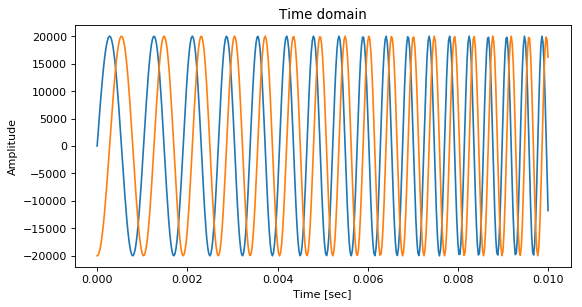

In [7]:
# Upchirp by complex exponential function
plot_wave(chirp(length=0.01), real_only=False)

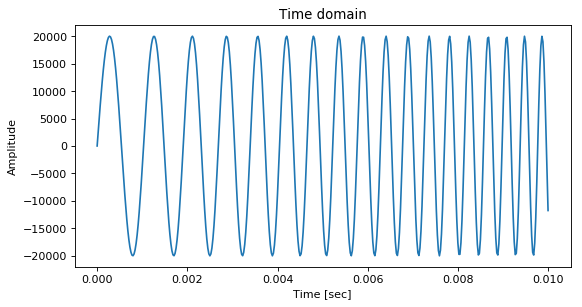

In [8]:
# Upchirp by cosine function
plot_wave(chirp_cos(length=0.01), real_only=True)

In [9]:
play(chirp(length=2.0))

Frequencies at peaks: [ 905.5 2614.5] Hz


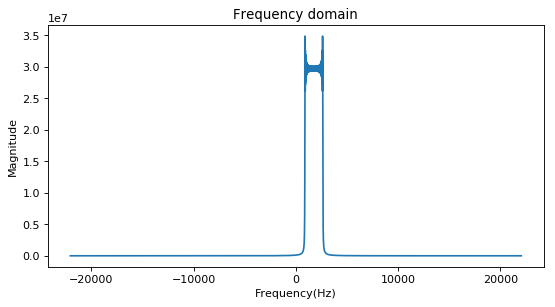

In [10]:
plot_fft(chirp(length=2.0))

Frequencies at peaks: [-2614.5  -905.5   905.5  2614.5] Hz


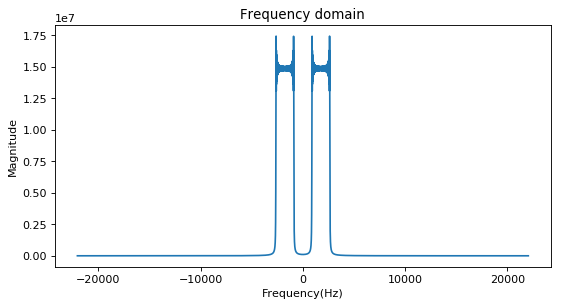

In [11]:
plot_fft(chirp_cos(length=2.0))

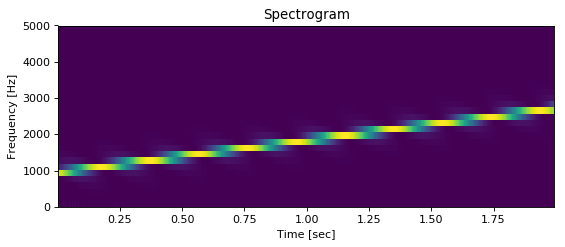

In [12]:
plot_spectrogram(chirp_cos(length=2.0), nperseg=256, band=30)

## Up chirp * up chirp

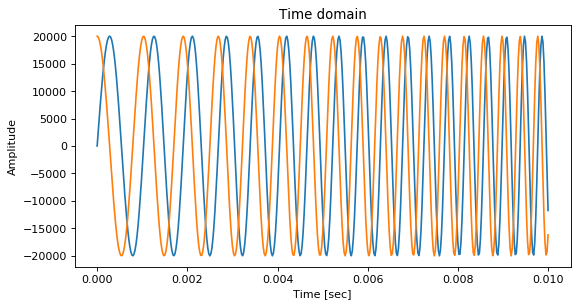

In [13]:
# Up chirp conjugate
plot_wave(chirp(length=0.01).conjugate(), real_only=False)

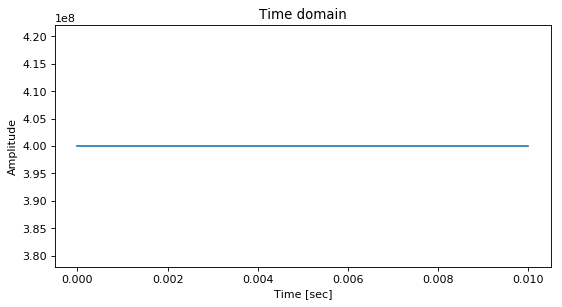

In [52]:
# Up chirp * up chirp conjugate (= down chirp) becomes DC
plot_wave(chirp(length=0.01) * chirp(length=0.01).conjugate())

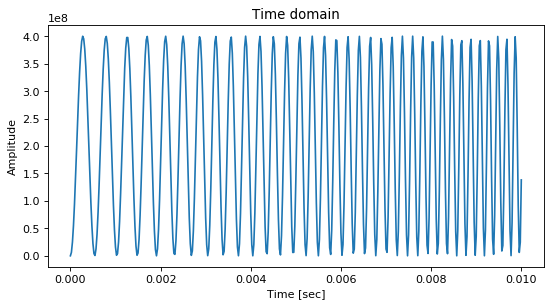

In [21]:
# Up chirp * up chirp becomes chirp with doubled frequency and DC offset
plot_wave(chirp_cos(length=0.01) * chirp_cos(length=0.01).conjugate())

In [20]:
# Up chirp * up chirp conjugate becomes silent
play(chirp(length=2.0) * chirp(length=2.0).conjugate())

Frequencies at peaks: [0.] Hz


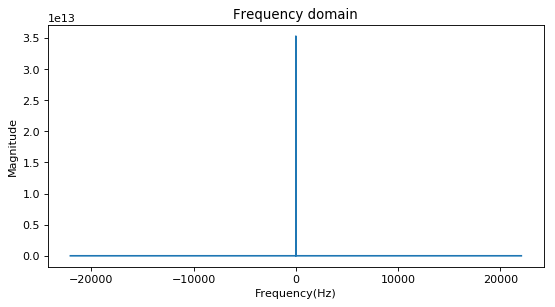

In [386]:
plot_fft(chirp(length=2.0) * chirp(length=2.0).conjugate())

Frequencies at peaks: [0.] Hz


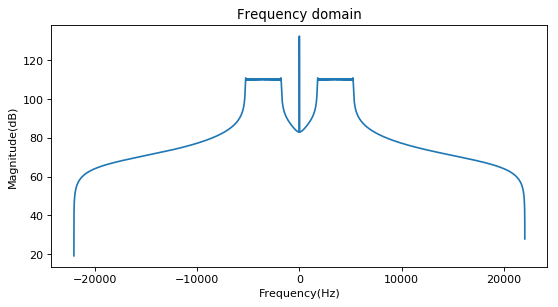

In [387]:
# Chirp squared term
plot_fft(chirp_cos(length=2.0) * chirp_cos(length=2.0), logscale=True)

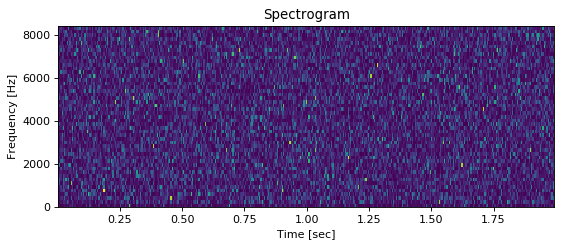

In [388]:
plot_spectrogram(chirp(length=2.0) * chirp(length=2.0).conjugate(), nperseg=256, band=50)

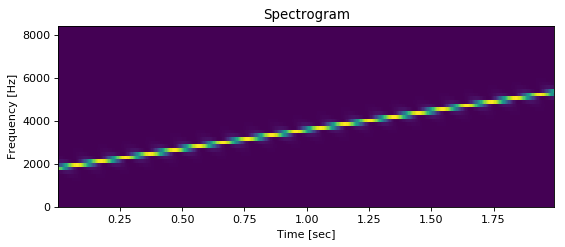

In [389]:
# Chirp squared term
plot_spectrogram(chirp_cos(length=2.0) * chirp_cos(length=2.0), nperseg=256, band=50)

## Up chirp * Down chirp

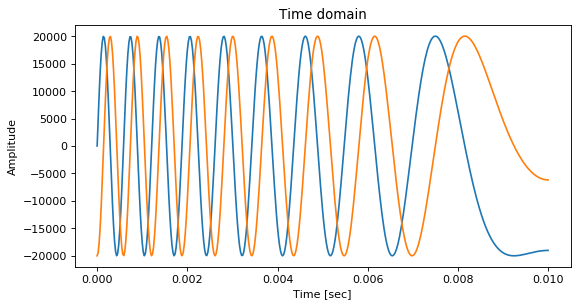

In [390]:
plot_wave(chirp(length=0.01, updown="down"), real_only=False)

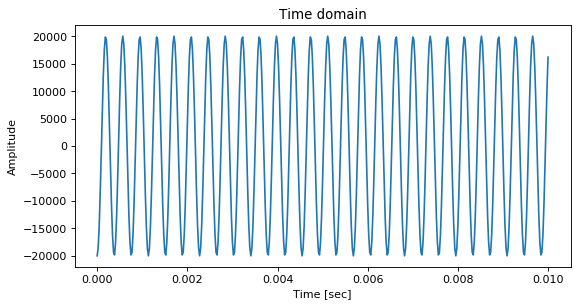

In [51]:
plot_wave(chirp(length=0.01, amp=sqrt(AMPLITUDE)) * chirp(length=0.01, amp=sqrt(AMPLITUDE), updown="down"))

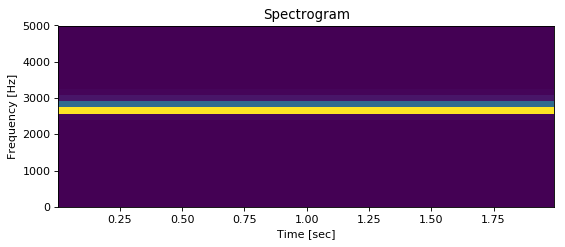

In [45]:
plot_spectrogram(chirp(length=2.0, amp=sqrt(AMPLITUDE)) * chirp(length=2.0, amp=sqrt(AMPLITUDE), updown="down"), nperseg=256, band=30)
play(chirp(length=2.0, amp=sqrt(AMPLITUDE)) * chirp(length=2.0, amp=sqrt(AMPLITUDE), updown="down"))

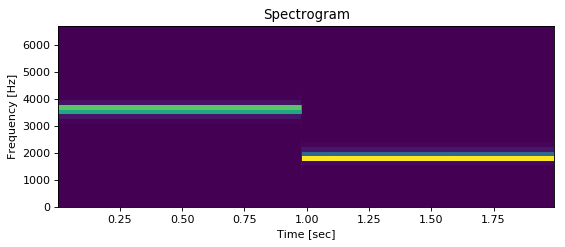

In [46]:
# Unsynchronized upchirp * downchirp
upchirp=chirp(length=2.0, amp=sqrt(AMPLITUDE))
plot_spectrogram(append(upchirp[45000:], upchirp[:45000]) * chirp(length=2.0, amp=sqrt(AMPLITUDE), updown="down"), nperseg=256, band=40)
play(append(upchirp[45000:], upchirp[:45000]) * chirp(length=2.0, amp=sqrt(AMPLITUDE), updown="down"))

Frequencies at peaks: [2640.] Hz


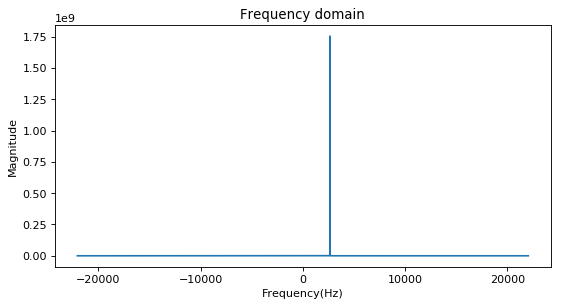

In [393]:
plot_fft(chirp(length=2.0, amp=sqrt(AMPLITUDE)) * chirp(length=2.0, amp=sqrt(AMPLITUDE), updown="down"))

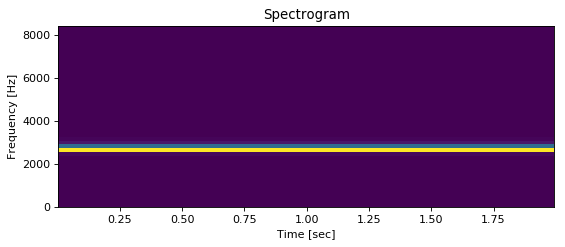

In [394]:
plot_spectrogram(chirp(length=2.0, amp=sqrt(AMPLITUDE)) * chirp(length=2.0, amp=sqrt(AMPLITUDE), updown="down"), nperseg=256, band=50)

## Radar system

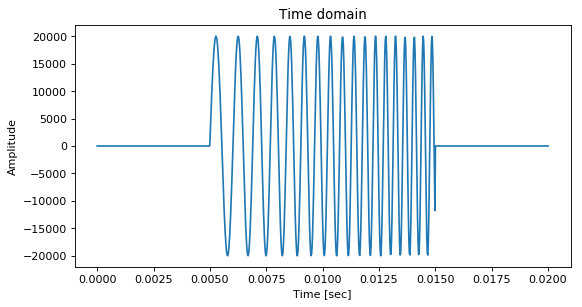

In [395]:
# Upchirp by cosine function (delay = chirp length in time * 0.5)
plot_wave(add_delay(chirp_cos(length=0.01), 0.5), real_only=True)

Frequencies at peaks: [0.] Hz


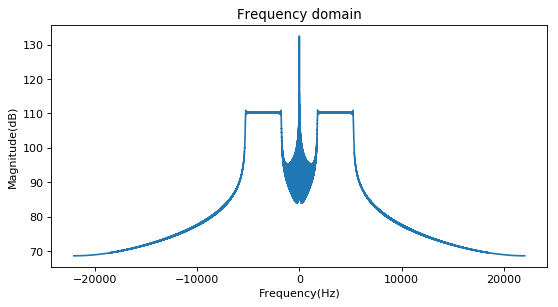

In [396]:
plot_fft(add_delay(chirp_cos(length=2.0), 0.0) * chirp_cos(f1=F1, f2=F1+(F2-F1)*2, length=4.0), logscale=True)

Frequencies at peaks: [-880.  880.] Hz


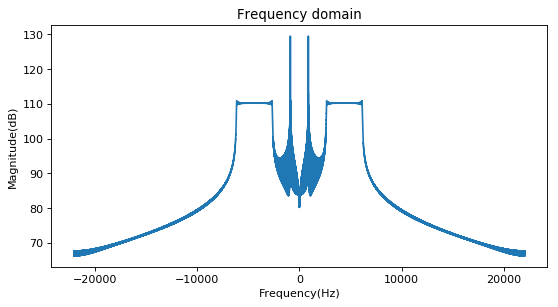

In [397]:
plot_fft(add_delay(chirp_cos(length=2.0), 0.5) * chirp_cos(f1=F1, f2=F1+(F2-F1)*2, length=4.0), logscale=True)

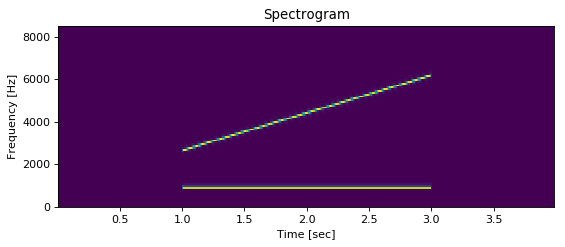

In [398]:
plot_spectrogram(add_delay(chirp_cos(length=2.0), 0.5) * chirp_cos(f1=F1, f2=F1+(F2-F1)*2, length=4.0), nperseg=512, band=100)

Frequencies at peaks: [-880. -528. -176.  176.  528.  880.] Hz


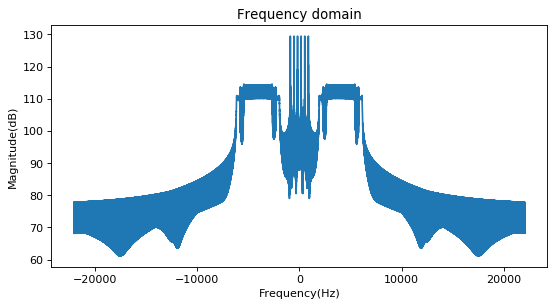

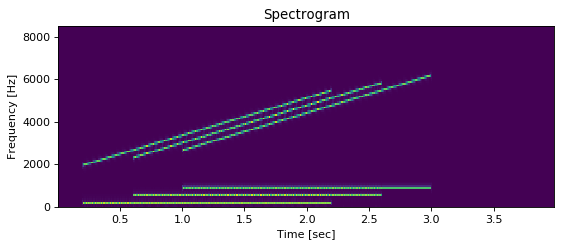

In [399]:
echo0 = add_delay(chirp_cos(length=2.0), 0.1)
echo1 = add_delay(chirp_cos(length=2.0), 0.3)
echo2 = add_delay(chirp_cos(length=2.0), 0.5)
echos = echo0 + echo1 + echo2
plot_fft(echos * chirp_cos(f1=F1, f2=F1+(F2-F1)*2, length=4.0), logscale=True)
plot_spectrogram(echos * chirp_cos(f1=F1, f2=F1+(F2-F1)*2, length=4.0), nperseg=512, band=100)

## Compress chirp in frequency domain (chirp signal under noise level)

### Complex chirp signal

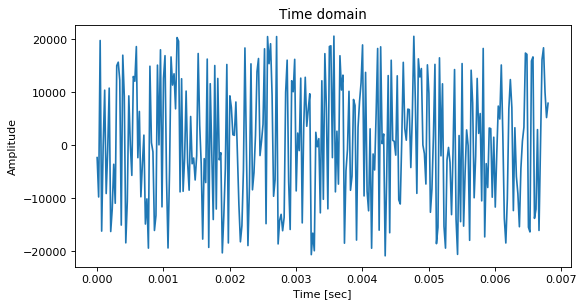

In [400]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_wave((chirp(length=2.0, amp=1000) + white_noise(length=2.0))[0:300], real_only=True)

Frequencies at peaks: [-18967.  -3130.   3130.  18967.] Hz


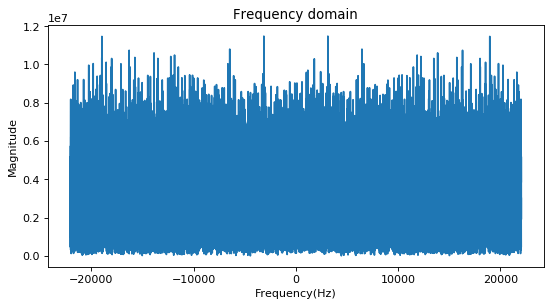

In [401]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((chirp(length=2.0, amp=1000) + white_noise(length=2.0)))

Frequencies at peaks: [0.] Hz


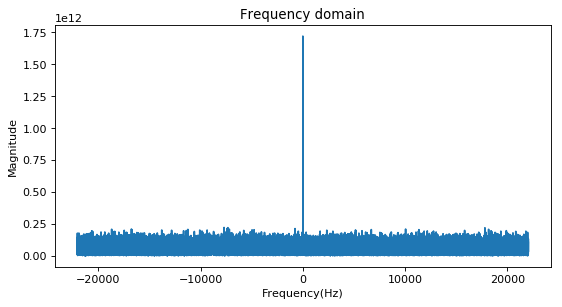

In [402]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((chirp(length=2.0, amp=1000) + white_noise(length=2.0)) * chirp(length=2.0).conjugate())

Frequencies at peaks: [2640.] Hz


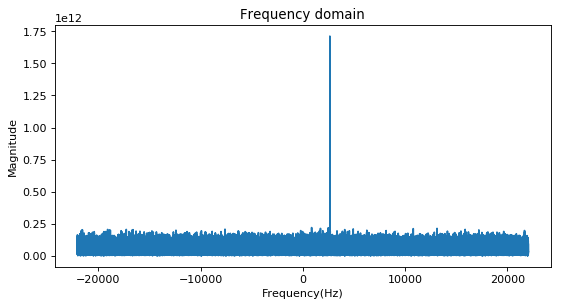

In [405]:
# Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((chirp(length=2.0, amp=1000) + white_noise(length=2.0)) * chirp(length=2.0, updown="down"))

Frequencies at peaks: [2640.] Hz


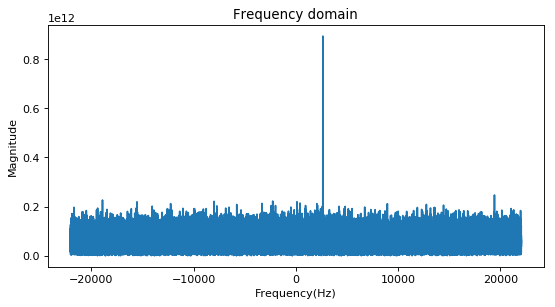

In [424]:
# Real Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((chirp_cos(length=2.0, amp=1000) + white_noise(length=2.0)) * chirp(length=2.0, updown="down"))

Frequencies at peaks: [-2640.  2640.] Hz


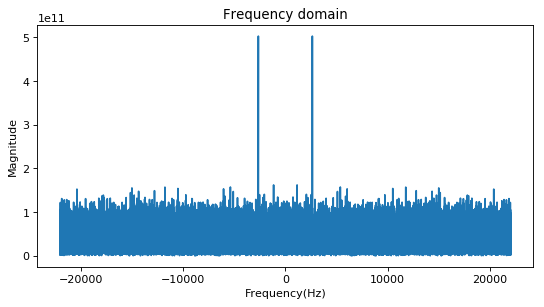

In [425]:
# Real Chirp signal under noise level (amplitude = 1000, noise amplitude = 20000)
plot_fft((chirp_cos(length=2.0, amp=1000) + white_noise(length=2.0)) * chirp_cos(length=2.0, updown="down"))

Frequencies at peaks: [2640.] Hz


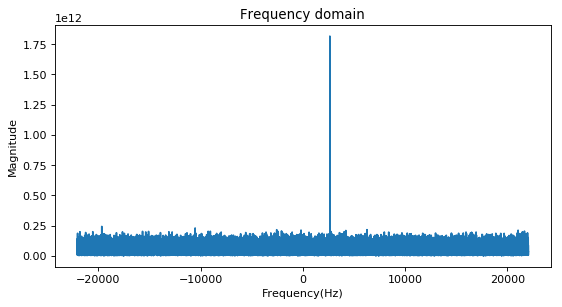

In [414]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft((real(chirp(length=2.0, amp=2000) + white_noise(length=2.0))) * chirp(length=2.0, updown="down"))

### Real chirp signal

__I concluded that this is the best Chrip compression technique for my project.__

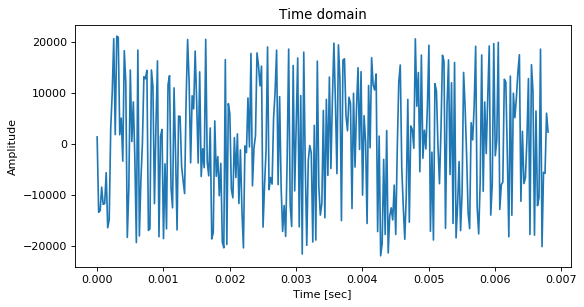

In [325]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_wave((chirp_cos(length=2.0, amp=2000) + white_noise(length=2.0))[0:300], real_only=True)

Frequencies at peaks: [-15673.  -13050.   -3249.5  -3177.   -1701.   -1107.5   1107.5   1701.
   3177.    3249.5  13050.   15673. ] Hz


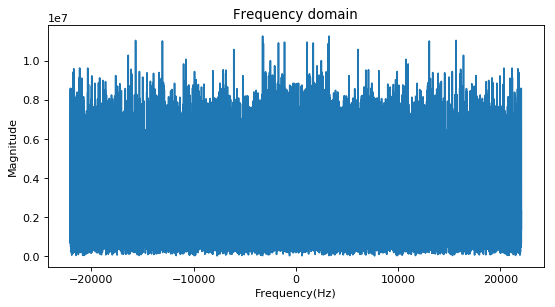

In [326]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft(chirp_cos(length=2.0, amp=2000) + white_noise(length=2.0))

Frequencies at peaks: [2640.] Hz


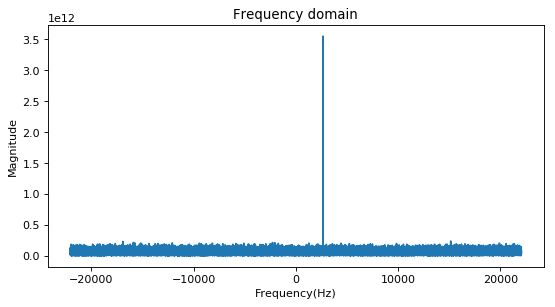

In [327]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft((chirp(length=2.0, amp=2000) + white_noise(length=2.0)) * chirp(length=2.0, updown="down"))

Frequencies at peaks: [2640.] Hz


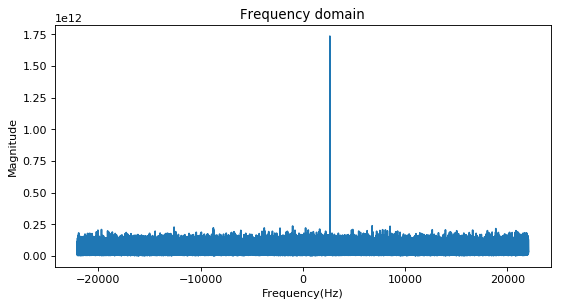

In [328]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft((chirp_cos(length=2.0, amp=2000) + white_noise(length=2.0)) * chirp(length=2.0, updown="down"))

Frequencies at peaks: [-2640.  2640.] Hz


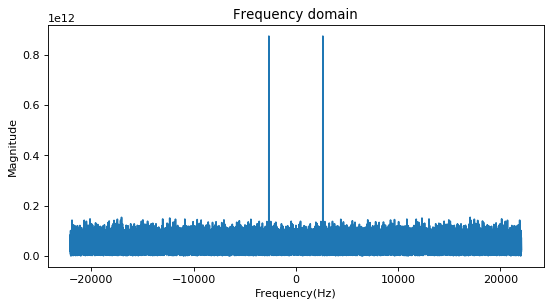

In [329]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft((chirp_cos(length=2.0, amp=2000) + white_noise(length=2.0)) * chirp_cos(length=2.0, updown="down"))

Frequencies at peaks: [2640.] Hz


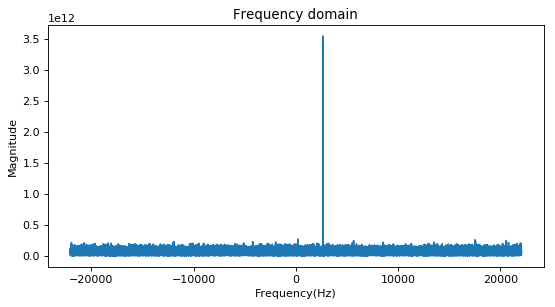

In [330]:
# Complex Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft((chirp(length=2.0, amp=2000) + white_noise(length=2.0)) * chirp(length=2.0, updown="down"))

Frequencies at peaks: [19973.5] Hz


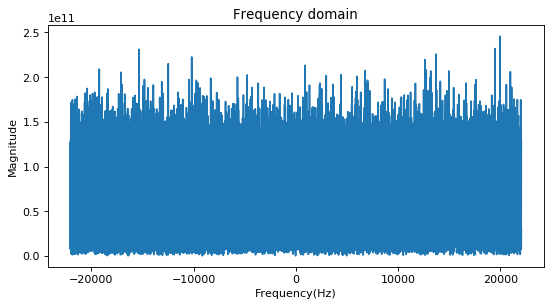

In [331]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
plot_fft(white_noise(length=2.0) * chirp(length=2.0, updown="down"))

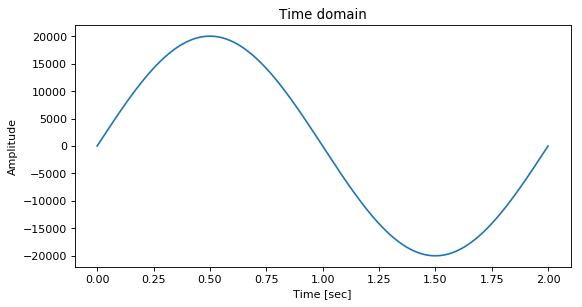

In [332]:
plot_wave(constant_noise(length=2.0, freq=0.5))

Frequencies at peaks: [0.] Hz
Frequencies at peaks: [0.] Hz


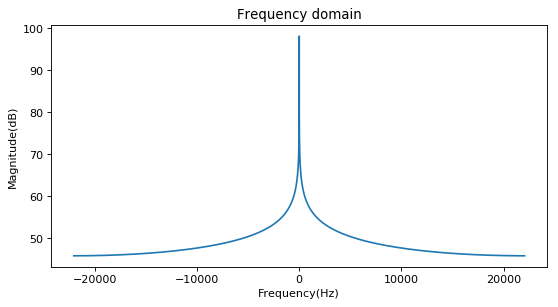

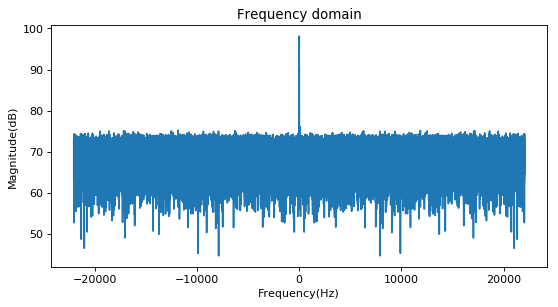

In [333]:
# Real Chirp signal under noise level (amplitude = 2000, noise amplitude = 20000)
constant_noises = constant_noise(freq=0, amp=AMPLITUDE*2, length=2.0) +\
    constant_noise(freq=0.1, amp=AMPLITUDE*2, length=2.0) +\
    constant_noise(freq=0.2, amp=AMPLITUDE*2, length=2.0) +\
    constant_noise(freq=0.3, amp=AMPLITUDE*2, length=2.0) +\
    constant_noise(freq=0.6, amp=AMPLITUDE*2, length=2.0) +\
    constant_noise(freq=1, amp=AMPLITUDE*2, length=2.0)
noise = white_noise(amp=AMPLITUDE*3, length=2.0) + constant_noises
plot_fft(constant_noises, logscale=True)
plot_fft(noise, logscale=True)

Frequencies at peaks: [-1213.  1213.] Hz
Frequencies at peaks: [0.] Hz


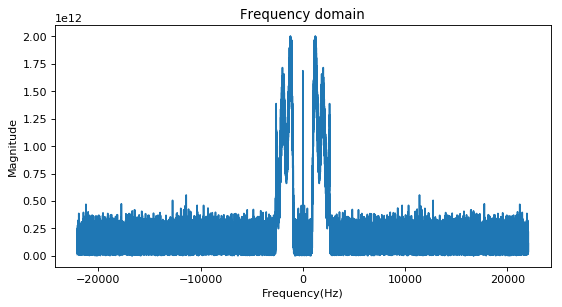

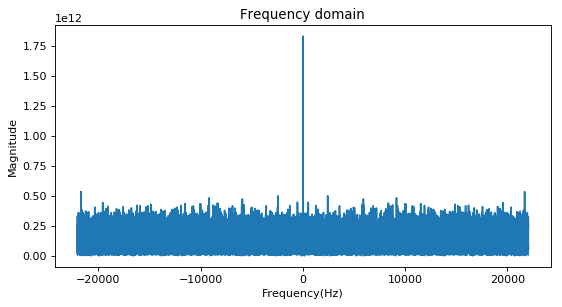

In [334]:
# Chirp signal under strong constant noises around zero Hz + white nose
plot_fft((chirp_cos(length=2.0, amp=2000) + noise) * chirp_cos(length=2.0), thres=0.999)
# Chirp signal under white nose
plot_fft((chirp_cos(length=2.0, amp=2000) + white_noise(amp=AMPLITUDE*3, length=2.0)) * chirp_cos(length=2.0), thres=0.999)

# Compress chirp in time domain

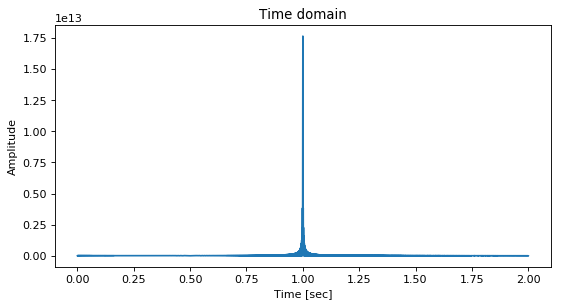

In [335]:
# Here, I use IFFT and FFT rather than filter functions
plot_wave(abs(ifft(fft(chirp(length=2.0)) * fft(chirp(length=2.0, updown="down")))), real_only=True)

C:\Users\shiny\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


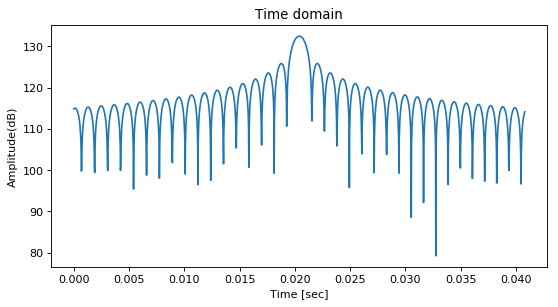

In [353]:
plot_wave(abs(ifft(fft(chirp(length=2.0)) * fft(chirp(length=2.0, updown="down"))))[43200:45000], real_only=True, logscale=True)

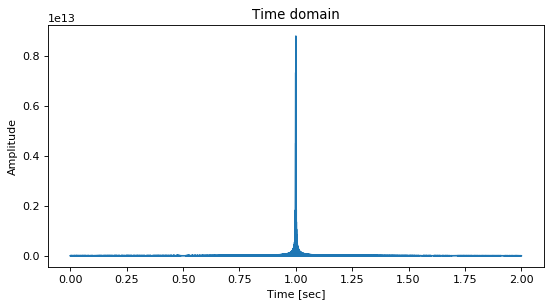

In [354]:
plot_wave(abs(ifft(fft(chirp_cos(length=2.0)) * fft(chirp_cos(length=2.0, updown="down")))), real_only=True)

C:\Users\shiny\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


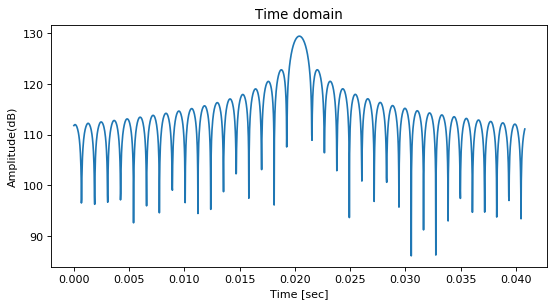

In [355]:
plot_wave(abs(ifft(fft(chirp_cos(length=2.0)) * fft(chirp(length=2.0, updown="down"))))[43200:45000], real_only=True, logscale=True)

## Compress unsynchronized chirp under noise level in time domain

In [356]:
noise = white_noise(length=2.0)
chirp = chirp_cos(length=2.0, amp=2000)  # Synchronized time frame
chirp1 = append(chirp[2000:], chirp[:2000])  # Unsynchronized time frame 1
chirp2 = append(chirp[5000:], chirp[:5000])  # Unsynchronized time frame 2
down_chirp = chirp_cos(length=2.0, amp=2000, updown="down")  # Matched filter for chirp compression

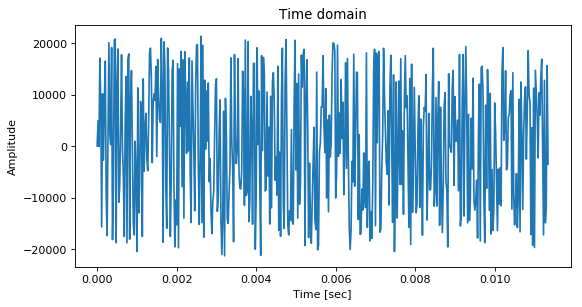

In [357]:
plot_wave((chirp + noise)[0:500])

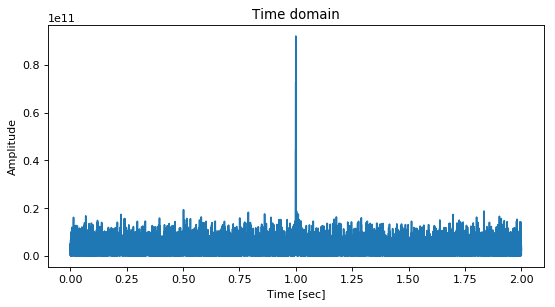

In [358]:
plot_wave(abs(ifft(fft(chirp + noise) * fft(down_chirp))), real_only=True)

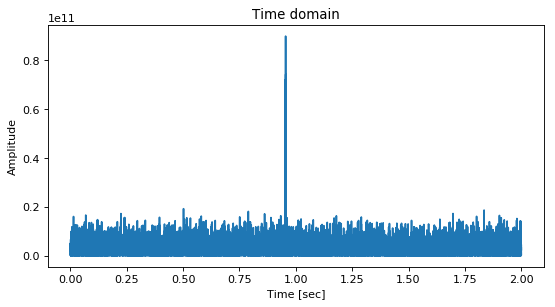

In [359]:
plot_wave(abs(ifft(fft(chirp1 + noise) * fft(down_chirp))), real_only=True)

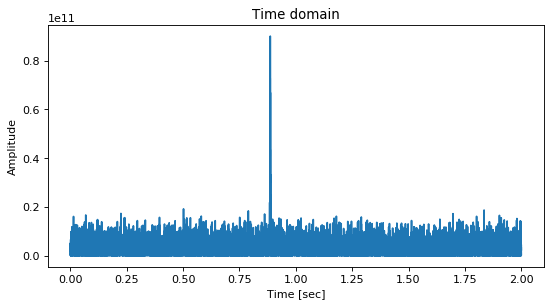

In [360]:
plot_wave(abs(ifft(fft(chirp2 + noise) * fft(down_chirp))), real_only=True)